<a href="https://colab.research.google.com/github/humble-phoenix/roblox_custom_detectron/blob/main/Copy_of_Roboflow_Custom_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [1]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="UYIfoReGmT7n2Xcejy8f")
project = rf.workspace("asu-uwfdw").project("liver-disease-n4mfd")
dataset = project.version(1).download("coco")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Liver-Disease-1 in coco:: 100%|██████████| 3984/3984 [00:01<00:00, 3252.77it/s]


In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("Liver_train", {}, "/content/Liver-Disease-1/train/_annotations.coco.json", "/content/Liver-Disease-1/train")
register_coco_instances("Liver_val", {}, "/content/Liver-Disease-1/valid/_annotations.coco.json", "/content/Liver-Disease-1/valid")
register_coco_instances("Liver_test", {}, "/content/Liver-Disease-1/test/_annotations.coco.json", "/content/Liver-Disease-1/test")


WARNING [10/29 02:23:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/29 02:23:13 d2.data.datasets.coco]: Loaded 2782 images in COCO format from /content/Liver-Disease-1/train/_annotations.coco.json


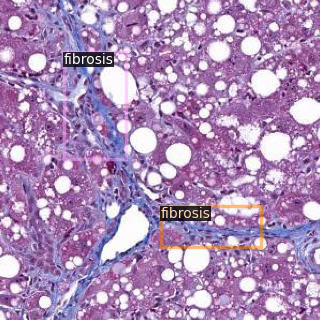

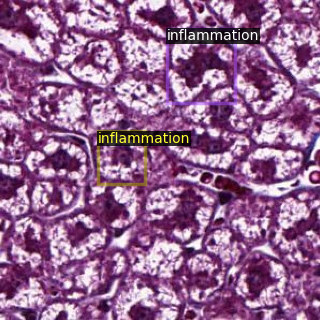

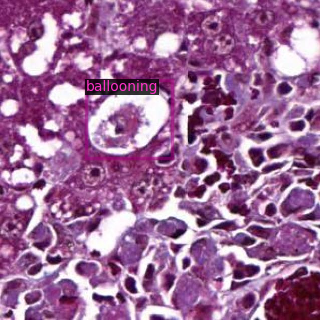

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("Liver_train")
dataset_dicts = DatasetCatalog.get("Liver_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [6]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [7]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Liver_train",)
cfg.DATASETS.TEST = ("Liver_train",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000  # Adjust the total number of iterations as needed
cfg.SOLVER.STEPS = (1500,)  # Adjust the milestone value to a smaller value
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/29 02:23:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
model_final_68b088.pkl: 421MB [00:01, 256MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/29 02:23:18 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


[10/29 02:24:06 d2.utils.events]:  eta: 1:10:48  iter: 19  total_loss: 1.94  loss_cls: 1.546  loss_box_reg: 0.2923  loss_rpn_cls: 0.1349  loss_rpn_loc: 0.01402    time: 2.1736  last_time: 1.8341  data_time: 0.0339  last_data_time: 0.0219   lr: 1.9981e-05  max_mem: 6859M
[10/29 02:24:54 d2.utils.events]:  eta: 1:14:05  iter: 39  total_loss: 1.577  loss_cls: 1.035  loss_box_reg: 0.3617  loss_rpn_cls: 0.1511  loss_rpn_loc: 0.01713    time: 2.2043  last_time: 2.2076  data_time: 0.0287  last_data_time: 0.0346   lr: 3.9961e-05  max_mem: 6859M
[10/29 02:25:40 d2.utils.events]:  eta: 1:13:31  iter: 59  total_loss: 1.094  loss_cls: 0.552  loss_box_reg: 0.3306  loss_rpn_cls: 0.1134  loss_rpn_loc: 0.01309    time: 2.2364  last_time: 2.4333  data_time: 0.0218  last_data_time: 0.0187   lr: 5.9941e-05  max_mem: 6859M
[10/29 02:26:24 d2.utils.events]:  eta: 1:11:02  iter: 79  total_loss: 1.309  loss_cls: 0.6447  loss_box_reg: 0.5809  loss_rpn_cls: 0.08436  loss_rpn_loc: 0.01118    time: 2.2311  last_

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[10/29 02:43:43 d2.utils.events]:  eta: 0:59:22  iter: 519  total_loss: 0.6791  loss_cls: 0.2883  loss_box_reg: 0.3749  loss_rpn_cls: 0.02215  loss_rpn_loc: 0.01175    time: 2.3409  last_time: 2.5191  data_time: 0.0259  last_data_time: 0.0350   lr: 0.00051948  max_mem: 6859M
[10/29 02:44:29 d2.utils.events]:  eta: 0:58:11  iter: 539  total_loss: 0.8439  loss_cls: 0.3071  loss_box_reg: 0.5105  loss_rpn_cls: 0.01753  loss_rpn_loc: 0.0104    time: 2.3385  last_time: 2.2676  data_time: 0.0227  last_data_time: 0.0298   lr: 0.00053946  max_mem: 6859M
[10/29 02:45:14 d2.utils.events]:  eta: 0:57:04  iter: 559  total_loss: 0.634  loss_cls: 0.2058  loss_box_reg: 0.3956  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.00988    time: 2.3365  last_time: 2.3040  data_time: 0.0240  last_data_time: 0.0374   lr: 0.00055944  max_mem: 6859M
[10/29 02:46:02 d2.utils.events]:  eta: 0:56:35  iter: 579  total_loss: 0.9144  loss_cls: 0.278  loss_box_reg: 0.5562  loss_rpn_cls: 0.02599  loss_rpn_loc: 0.009375    time: 

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[10/29 03:03:19 d2.utils.events]:  eta: 0:40:08  iter: 1019  total_loss: 0.7579  loss_cls: 0.2613  loss_box_reg: 0.4444  loss_rpn_cls: 0.01739  loss_rpn_loc: 0.01035    time: 2.3460  last_time: 2.4918  data_time: 0.0255  last_data_time: 0.0101   lr: 0.001  max_mem: 6859M
[10/29 03:04:06 d2.utils.events]:  eta: 0:39:29  iter: 1039  total_loss: 0.7367  loss_cls: 0.2615  loss_box_reg: 0.454  loss_rpn_cls: 0.01638  loss_rpn_loc: 0.009685    time: 2.3454  last_time: 2.5020  data_time: 0.0232  last_data_time: 0.0199   lr: 0.001  max_mem: 6859M
[10/29 03:04:53 d2.utils.events]:  eta: 0:38:47  iter: 1059  total_loss: 0.7416  loss_cls: 0.2693  loss_box_reg: 0.4475  loss_rpn_cls: 0.01696  loss_rpn_loc: 0.008796    time: 2.3461  last_time: 2.2684  data_time: 0.0270  last_data_time: 0.0313   lr: 0.001  max_mem: 6859M
[10/29 03:05:41 d2.utils.events]:  eta: 0:38:03  iter: 1079  total_loss: 0.7047  loss_cls: 0.2413  loss_box_reg: 0.4364  loss_rpn_cls: 0.01443  loss_rpn_loc: 0.01062    time: 2.3469  

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[10/29 03:22:57 d2.utils.events]:  eta: 0:19:53  iter: 1519  total_loss: 0.6362  loss_cls: 0.1919  loss_box_reg: 0.3834  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.009579    time: 2.3487  last_time: 2.5035  data_time: 0.0254  last_data_time: 0.0385   lr: 5e-05  max_mem: 6859M
[10/29 03:23:44 d2.utils.events]:  eta: 0:19:03  iter: 1539  total_loss: 0.4474  loss_cls: 0.1414  loss_box_reg: 0.2782  loss_rpn_cls: 0.009478  loss_rpn_loc: 0.007452    time: 2.3485  last_time: 2.1152  data_time: 0.0217  last_data_time: 0.0202   lr: 5e-05  max_mem: 6859M
[10/29 03:24:32 d2.utils.events]:  eta: 0:18:14  iter: 1559  total_loss: 0.6651  loss_cls: 0.2289  loss_box_reg: 0.4447  loss_rpn_cls: 0.009384  loss_rpn_loc: 0.008053    time: 2.3496  last_time: 2.4936  data_time: 0.0234  last_data_time: 0.0102   lr: 5e-05  max_mem: 6859M
[10/29 03:25:19 d2.utils.events]:  eta: 0:17:24  iter: 1579  total_loss: 0.626  loss_cls: 0.2184  loss_box_reg: 0.381  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.008172    time: 2.349

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21337), started 0:08:24 ago. (Use '!kill 21337' to kill it.)

<IPython.core.display.Javascript object>

In [11]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/29 03:50:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [10/29 03:50:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


FileNotFoundError: ignored

# Inference with Detectron2 Saved Weights



In [ ]:
%ls ./output/

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
